# Sorption enthalpy calculations

Sorption enthalpy, $\Delta H_{ads}$, is an indication of the strength of the adsorbate-material
interaction and can be estimated through several methods.

## Isosteric enthalpy (Clausius-Clapeyron)

In order to calculate $\Delta H_{ads}$, at least two isotherms which were
taken at different temperatures are required.

First, make sure the data is imported.

In [1]:
# import isotherms
%run import.ipynb
%matplotlib inline

# import the characterisation module
import pygaps.characterisation as pgc

Selected 5 isotherms with nitrogen at 77K
Selected 2 room temperature calorimetry isotherms
Selected 2 isotherms for IAST calculation
Selected 3 isotherms for isosteric enthalpy calculation
The file version is None while the parser uses version d546195. Strange things might happen, so double check your data.


Let's quickly plot the isotherms to see how they look. We put the temperature of
the experiment in the legend by using the `lgd_keys` keyword.

<Axes: xlabel='Pressure [$bar$]', ylabel='Loading [$mmol\\/g^{-1}$]'>

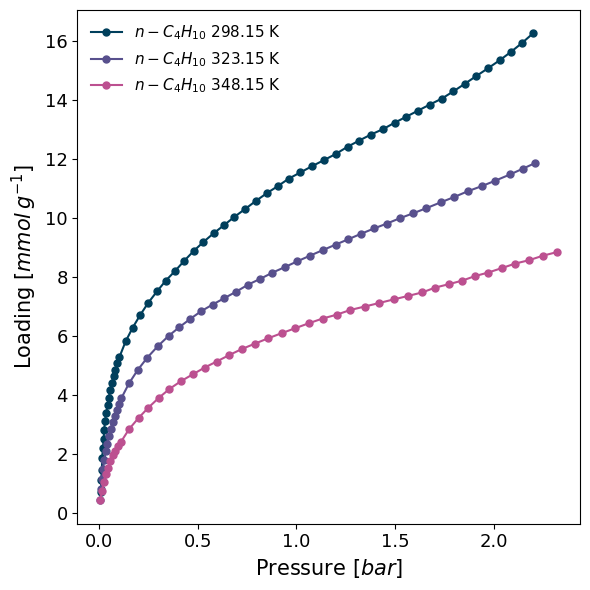

In [2]:
# import the graphing module
import pygaps.graphing as pgg

pgg.plot_iso(
    isotherms_isosteric,
    lgd_keys=['adsorbate', 'temperature'],
)

The isotherms look good, except perhaps a bit of measurement error in the low pressure region.

The isosteric enthalpy calculation takes the list of the isotherms and returns
the results as a dictionary. Using the `verbose` keyword, we also generate a
graph that includes an error bar.

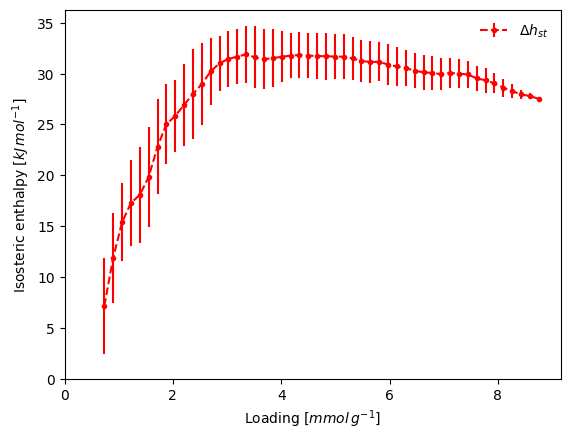

In [3]:
result_dict = pgc.isosteric_enthalpy(isotherms_isosteric, verbose=True)

The inaccuracy in the low pressure region has contributed to the odd enthalpy
curve. One other option would be to first fit a model to each isotherm, then
use it for the enthalpy determination.

Let's try a Double Site Langmuir model and then re-run the isosteric
calculation.

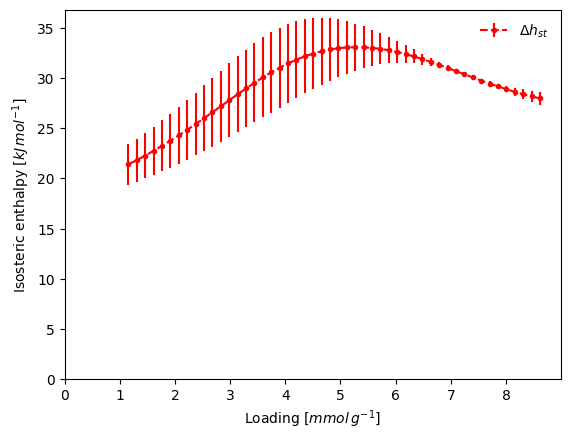

In [4]:
from pygaps.modelling import model_iso
models_isosteric = [
    model_iso(iso, model="dslangmuir")
    for iso in isotherms_isosteric
]
result_dict = pgc.isosteric_enthalpy(models_isosteric, verbose=True)

More information about the functions and their use can be found in the [manual](../manual/characterisation.rst).

## Whittaker method



The Whittaker method uses a Tóth’s modification of Polanyi's potential theory to determine enthalpy of adsorption from a single isotherm fitted with a suitable model.
We loaded the example isotherm before, so we can now plot it.

<Axes: xlabel='Pressure [$bar$]', ylabel='Loading [$mmol\\/g^{-1}$]'>

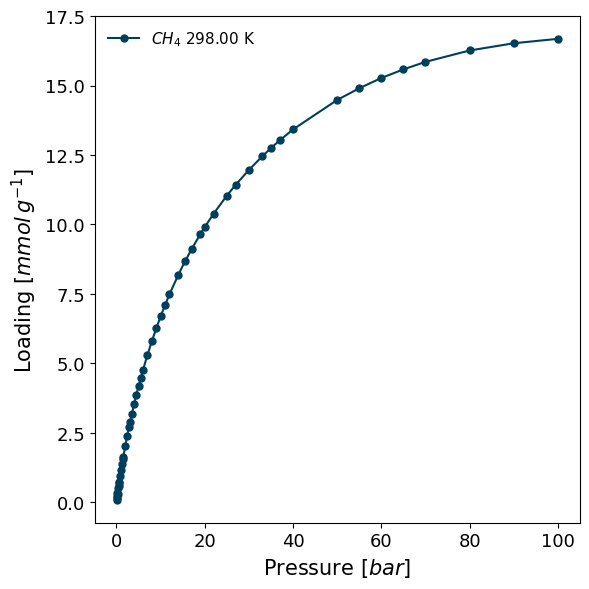

In [5]:
pgg.plot_iso(
    isotherms_enth_whittaker,
    lgd_keys=['adsorbate', 'temperature'],
    pressure_unit='bar'
)

The code can accept a ModelIsotherm of the required type. Note that this isotherm must be in correct pressure mode (`absolute`) and units: (`Pa`).

Attempting to model using Langmuir.
Model Langmuir success, RMSE is 0.00748
Attempting to model using DSLangmuir.
Model DSLangmuir success, RMSE is 0.00368
Attempting to model using TSLangmuir.
Model TSLangmuir success, RMSE is 0.027
Attempting to model using Toth.
Model Toth success, RMSE is 0.00493
Attempting to model using DSToth.
Model DSToth success, RMSE is 0.0167
Attempting to model using ChemiPhysisorption.
Model ChemiPhysisorption success, RMSE is 0.205
Best model fit is DSLangmuir.


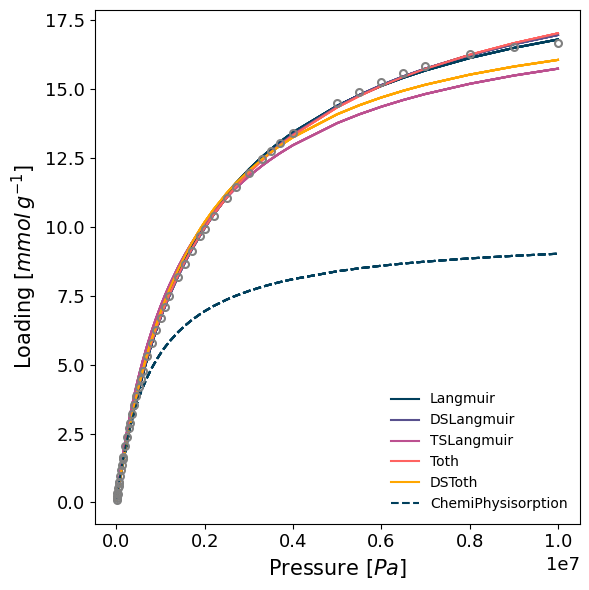

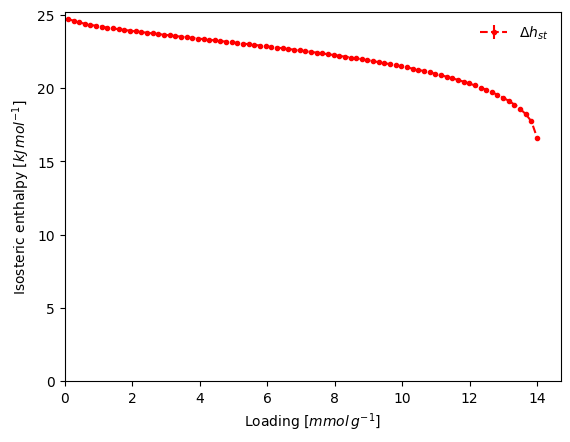

In [6]:
import pygaps.modelling as pgm

for iso in isotherms_enth_whittaker:
    iso.convert_pressure(mode_to="absolute", unit_to="Pa")
models_whittaker = pgm.model_iso(
    isotherms_enth_whittaker[0], 
    model=pgm._WHITTAKER_MODELS, 
    verbose=True
)
result_dict_whitt = pgc.enthalpy_sorption_whittaker(models_whittaker, verbose=True)

Alternatively, the PointIsotherm and the desired model can be passed as parameters, and fitting is performed automatically before the method is applied.

Attempting to model using Langmuir.
Model Langmuir success, RMSE is 0.00748
Attempting to model using DSLangmuir.
Model DSLangmuir success, RMSE is 0.00368
Attempting to model using TSLangmuir.
Model TSLangmuir success, RMSE is 0.027
Attempting to model using Toth.
Model Toth success, RMSE is 0.00493
Attempting to model using DSToth.
Model DSToth success, RMSE is 0.0167
Attempting to model using ChemiPhysisorption.
Model ChemiPhysisorption success, RMSE is 0.205
Best model fit is DSLangmuir.


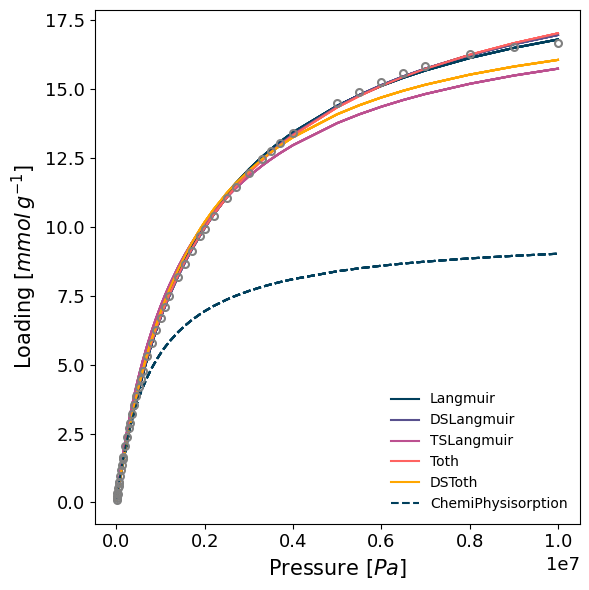

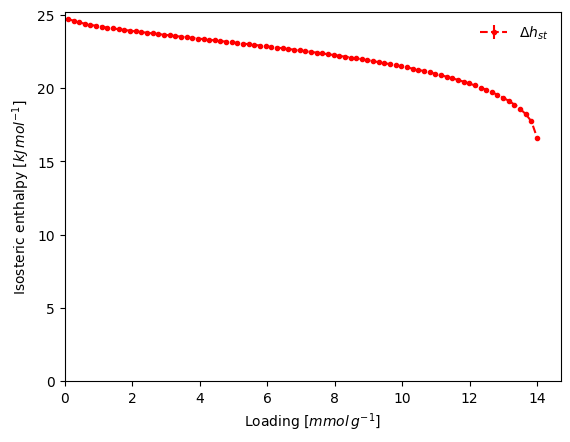

In [7]:
result_dict_whitt = pgc.enthalpy_sorption_whittaker(
    isotherms_enth_whittaker[0], 
    model="guess", 
    verbose=True
)

## Comparing Whittaker and Clausius-Clapeyron

How do these methods compare? We can use the Whittaker method on each of the isotherms in `isotherms_isosteric`, and compare with the Clausius-Clapeyron results in `result_dict`.

298.15: 0.009565136818274825
323.15: 0.005256038450545493
348.15: 0.009516772628472047


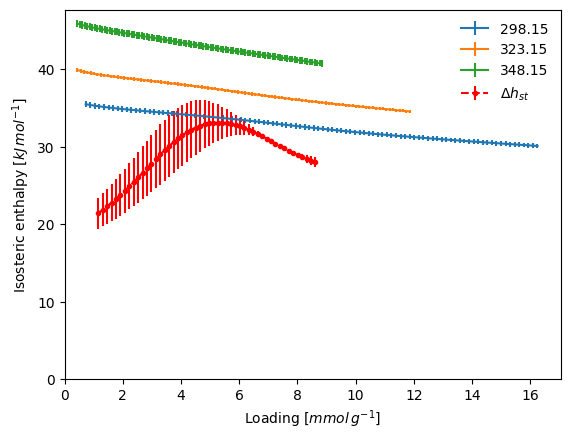

In [42]:
import pygaps.graphing as pgg
import matplotlib.pyplot as plt

_, ax = plt.subplots(1, 1)  # set up an ax to plot on

for i in isotherms_isosteric:
    # Calculate heat of adsorpation with whittaker method
    whittaker = pgc.enthalpy_sorption_whittaker(
        i, 
        model='dslangmuir',  # using DSLangmuir as previously showed good fit
        verbose=False
    )
    print(
        f"{i.temperature}: {whittaker['model_isotherm'].model.rmse}"
    )  # check that fit is reasonable for all models
    ax.errorbar( # and plotting
        whittaker['loading'],
        whittaker['enthalpy_sorption'],
        yerr=whittaker['std_errs'],  # with error bars
        label=str(i.temperature),
    )

# Now plotting Clausis-Clapeyron enthalpies
pgg.calc_graphs.isosteric_enthalpy_plot(
    result_dict['loading'],
    result_dict['isosteric_enthalpy'],
    result_dict['std_errs'],
    units=isotherms_isosteric[0].units,
    ax=ax
)

ax.legend(frameon=False)

A reasonable match in terms of magnitude of $\Delta H_{st}$, but not in terms of the overall trend. The Clausius-Clapeyron method predicts increasing enthalpy with loading up to 6 mmol g<sup>-1</sup>, while the Whittaker method predicts a continuous decrease. Whittaker approximation will always give this decreasing trend.

What happens when we use a different model, say `Toth`? 

CalculationError: Fitting routine for Toth failed with error:
	The maximum number of function evaluations is exceeded.
Try a different starting point in the nonlinear optimization
by passing a dictionary of parameter guesses, param_guess, to the constructor.
Default starting guess for parameters:
[1.78673000e+01 4.93900934e-05 1.00000000e+00]


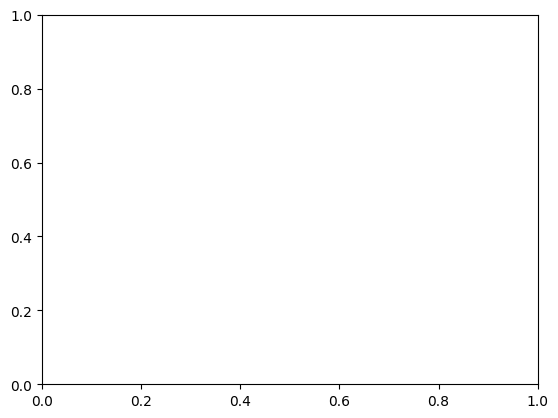

In [46]:
import pygaps.graphing as pgg
import matplotlib.pyplot as plt

_, ax = plt.subplots(1, 1)  # set up an ax to plot on

for i in isotherms_isosteric:
    # Calculate heat of adsorpation with whittaker method
    whittaker = pgc.enthalpy_sorption_whittaker(
        i, 
        model='toth',  # using DSToth
        verbose=False
    )
    print(
        f"{i.temperature}: {whittaker['model_isotherm'].model.rmse}"
    )  # check that fit is reasonable for all models
    ax.errorbar( # and plotting
        whittaker['loading'],
        whittaker['enthalpy_sorption'],
        yerr=whittaker['std_errs'],  # with error bars
        label=str(i.temperature),
    )

# Now plotting Clausis-Clapeyron enthalpies
pgg.calc_graphs.isosteric_enthalpy_plot(
    result_dict['loading'],
    result_dict['isosteric_enthalpy'],
    result_dict['std_errs'],
    units=isotherms_isosteric[0].units,
    ax=ax
)

ax.legend(frameon=False)

This gives an error as `pgm.model_iso()` can't fit the model. We can try to increase the number of function evaluatins `max_nfev` to see if that helps.

298.15: 0.020847257578099514
323.15: 0.01520385363705269
348.15: 0.008170243232597895


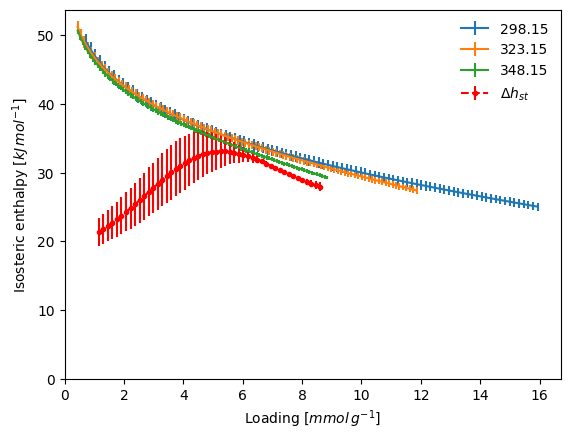

In [51]:
import pygaps.graphing as pgg
import matplotlib.pyplot as plt

_, ax = plt.subplots(1, 1)  # set up an ax to plot on

for i in isotherms_isosteric:
    # Calculate heat of adsorpation with whittaker method
    whittaker = pgc.enthalpy_sorption_whittaker(
        i, 
        model='toth',  # using Toth
        verbose=False,
        **{'max_nfev': 1e5},  # Increasing number of function evaluations
    )
    print(
        f"{i.temperature}: {whittaker['model_isotherm'].model.rmse}"
    )  # check that fit is reasonable for all models
    ax.errorbar( # and plotting
        whittaker['loading'],
        whittaker['enthalpy_sorption'],
        yerr=whittaker['std_errs'],  # with error bars
        label=str(i.temperature),
    )

# Now plotting Clausis-Clapeyron enthalpies
pgg.calc_graphs.isosteric_enthalpy_plot(
    result_dict['loading'],
    result_dict['isosteric_enthalpy'],
    result_dict['std_errs'],
    units=isotherms_isosteric[0].units,
    ax=ax
)

ax.legend(frameon=False)